In [ ]:
#GoogleDriveからマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ライブラリインポート
import numpy as np
import cv2
import os


In [ ]:
#データの読み込みとリサイズ
def load_and_resize_images(directory, img_height, img_width):
    images = []
    for filename in sorted(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (img_width, img_height))
            img_resized = img_resized[..., np.newaxis]
            images.append(img_resized)
    return images

img_height, img_width = 128, 128

# 各データセットのディレクトリパスを指定
train_image_dir = "/content/drive/MyDrive/dataset_1000/実験/train/images"
train_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/train/masks"

val_image_dir = "/content/drive/MyDrive/dataset_1000/実験/val/images"
val_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/val/masks"

test_image_dir = "/content/drive/MyDrive/test/images"
test_mask_dir = "/content/drive/MyDrive/test/masks"

# 各データセットを読み込む
X_train = load_and_resize_images(train_image_dir, img_height, img_width)
y_train = load_and_resize_images(train_mask_dir, img_height, img_width)

X_val = load_and_resize_images(val_image_dir, img_height, img_width)
y_val = load_and_resize_images(val_mask_dir, img_height, img_width)

X_test = load_and_resize_images(test_image_dir, img_height, img_width)
y_test = load_and_resize_images(test_mask_dir, img_height, img_width)



In [ ]:
# 画像とマスクの形状を変更

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
#正規化
# 画像とマスクの形状を変更し、正規化を行う（これはそのままでOK）
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train) / 255.0
X_val = np.array(X_val) / 255.0
y_val = np.array(y_val) / 255.0
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test) / 255.0

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation
from tensorflow.keras.models import Model

def vgg(input_shape):
    # 入力層
    inputs = Input(input_shape)

    # VGGスタイルのエンコーダ
    # ブロック1
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # ブロック2
    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # ブロック3
    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # ブロック4
    c4 = Conv2D(512, (3, 3), padding='same')(p3)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(512, (3, 3), padding='same')(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # ミドルブロック（ボトルネック）
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # シンプルなアップサンプリングを使用したデコーダ
    u6 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)

    u7 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)

    u8 = UpSampling2D((2, 2))(c7)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)

    u9 = UpSampling2D((2, 2))(c8)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)

    # 出力層
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# モデルのインスタンス化
input_shape = (256, 256, 1)  # 例: 256x256のグレースケール画像
model = vgg(input_shape)

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                             

In [ ]:
import tensorflow as tf

# IoU関数の定義
def iou(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = intersection / union
    return iou

# 精度を計算する関数
def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# 再現率を計算する関数
def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# F1スコアを計算する関数
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[iou, precision, recall, f1_score])

# 早期停止のコールバックを設定
early_stopping = EarlyStopping(
    monitor='val_loss',  # 監視する指標
    patience=10,         # 10エポック改善がなければ停止
    verbose=1,           # 進行状況のメッセージ表示
    restore_best_weights=True  # 最良のモデルの重みを復元
)


In [ ]:
# モデルのトレーニング（早期停止をコールバックとして追加）
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,  # 最大エポック数
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # 早期停止のコールバックを追加
)

Epoch 1/50
100/100 [==============================] - 32s 113ms/step - loss: 0.3502 - iou: 0.7960 - precision: 0.9040 - recall: 0.9991 - f1_score: 0.9490 - val_loss: 0.3034 - val_iou: 0.8021 - val_precision: 0.9032 - val_recall: 0.9994 - val_f1_score: 0.9485
Epoch 2/50
100/100 [==============================] - 10s 101ms/step - loss: 0.2580 - iou: 0.8424 - precision: 0.9039 - recall: 0.9993 - f1_score: 0.9490 - val_loss: 0.2594 - val_iou: 0.8406 - val_precision: 0.9027 - val_recall: 0.9989 - val_f1_score: 0.9481
Epoch 3/50
100/100 [==============================] - 10s 102ms/step - loss: 0.2374 - iou: 0.8492 - precision: 0.9038 - recall: 0.9991 - f1_score: 0.9489 - val_loss: 0.2372 - val_iou: 0.8432 - val_precision: 0.9026 - val_recall: 0.9988 - val_f1_score: 0.9480
Epoch 4/50
100/100 [==============================] - 10s 103ms/step - loss: 0.2280 - iou: 0.8541 - precision: 0.9047 - recall: 0.9981 - f1_score: 0.9489 - val_loss: 0.2327 - val_iou: 0.8504 - val_precision: 0.9076 - val_re

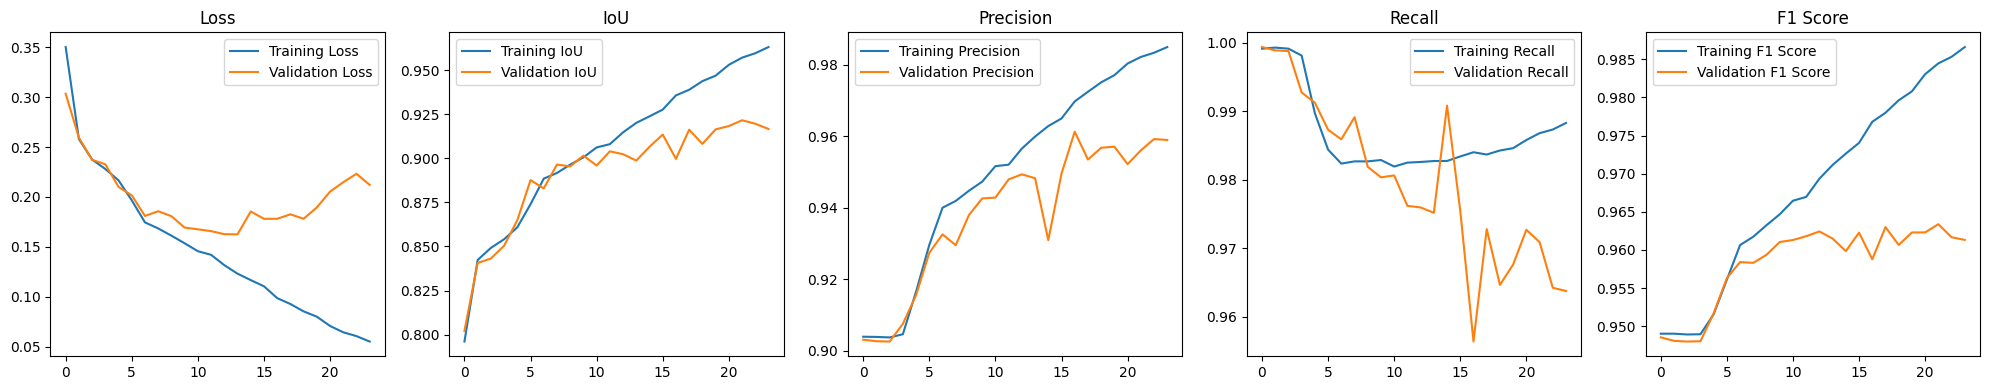

In [ ]:
import matplotlib.pyplot as plt
# 学習のロスと評価指標の履歴をプロット
plt.figure(figsize=(20, 4))

# ロスの履歴をプロット
plt.subplot(1, 5, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# IoUの履歴をプロット
plt.subplot(1, 5, 2)
plt.plot(history.history['iou'], label='Training IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.legend()
plt.title('IoU')

# 精度の履歴をプロット
plt.subplot(1, 5, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.legend()
plt.title('Precision')

# 再現率の履歴をプロット
plt.subplot(1, 5, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.legend()
plt.title('Recall')

# F1スコアの履歴をプロット（オプショナル）
plt.subplot(1, 5, 5)
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()

# グラフを保存
plt.savefig('training_graphs.png')
plt.show()





In [ ]:
import os
from tensorflow.keras.models import Model

# 保存先のフォルダパスを指定
save_dir = '/content/drive/MyDrive/dataset_1000/model'

# 指定したフォルダが存在しない場合は作成
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# モデルの保存先のパスを指定
model_save_path = os.path.join(save_dir, 'vgg_1000_低解像度_model.h5')

# モデルをHDF5形式で保存
model.save(model_save_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(X_test, batch_size=8)

13/13 [==============================] - 2s 109ms/step


In [ ]:
threshold = 0.5
predictions_t = (predictions > threshold).astype(np.uint8)


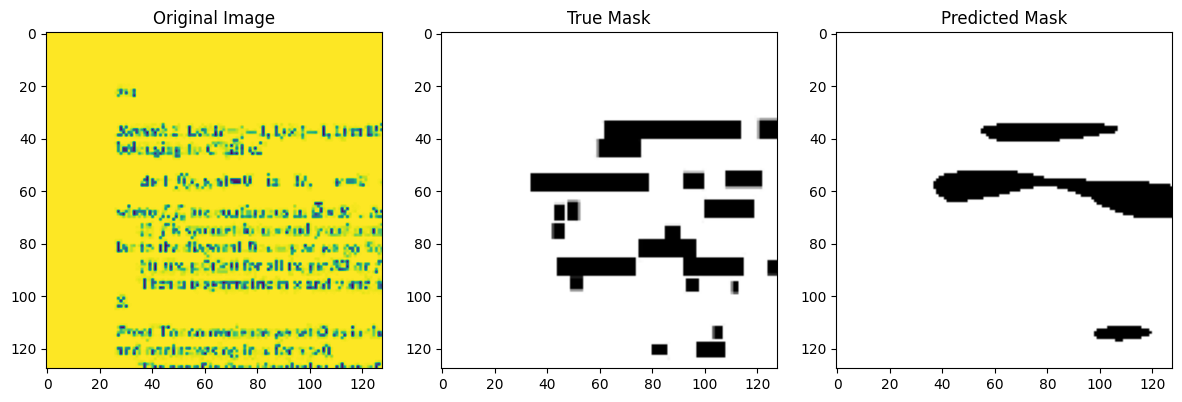

In [ ]:
import matplotlib.pyplot as plt

idx = 0  # 表示する画像のインデックス

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predictions_t[idx].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.savefig('result.png')
plt.show()
